# MovieLens 100K Collaborative Filtering

This is my implementation of using a collaborative filtering for movie recommendation model on MovieLens 100k Dataset.

## Dataset

The [MovieLens 100k Dataset](https://grouplens.org/datasets/movielens/100k/) was released in 1998 which contains 100,000 ratings from 1000 users on 1700 movies.  The dataset is about 5MB in size. The data can be downloaded from this [link](http://files.grouplens.org/datasets/movielens/ml-100k.zip)

## Loading the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import math

The data is stored in ```u.data``` which is tab separated files where each row is  ```user id | item id | rating | timestamp```. We are also intersted in the file ```u.item``` that contains information about the  movies. It is also a  a tab separated file where eac hrow is ```movie id | movie title | release date | video release date | IMDb URL | unknown | Action | Adventure | Animation | Children's | Comedy | Crime | Documentary | Drama | Fantasy | Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi | Thriller | War | Western```. The movie ids are the ones used in the u.data data set.

In [3]:
df_data = pd.read_csv('data/u.data', 
                      delimiter='\t', 
                      header=None, 
                      names = ['user id', 'item id', 'rating', 'timestamp'])
df_data.head()

,user id,item id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
df_movies = pd.read_csv('data/u.item', 
                      delimiter='|', 
                      header=None,
                      encoding='latin-1',
                      names = ['movie id', 'movie title', 'release date', 'video release date',
                               'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children',
                               'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',  'Film-Noir',
                               'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])
df_movies.head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [5]:
# shape of training data
len(df_data)

100000

we can add the movie name to the dataframe from ```u.item``` dataset so that is is easier for us to follow

In [6]:
df = df_data.merge(df_movies[['movie id', 'movie title']], left_on='item id', right_on='movie id').drop('movie id', 1)
df.head()

,user id,item id,rating,timestamp,movie title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


## Train/Test Split

At this point, it is a good idea to split the data into training data and testing data where the former is used in training the model while the later is used to evaluate its performance on unseen data before deploying it into a production environment.

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_val = train_test_split(df, test_size=0.2, random_state=113)
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")

X_train shape: (80000, 5)
X_val shape: (20000, 5)


## Building the Model

We will try to solve collaborative filtering problems by decomposing the user rating matrix R into two smaller matrices U and I where each row of the U matrix descibes a user and each column of matrix I descibes a movie. 

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [10]:
class CollabModel(nn.Module):
    
    def __init__(self, no_factors, no_users, no_items):
        super(CollabModel, self).__init__()
        self.user_weight = nn.Parameter(torch.randn(no_users, no_factors))
        #self.user_bias = torch.randn(no_users, 1)
        self.item_weight = nn.Parameter(torch.randn(no_items, no_factors))
        #self.item_bias = torch.randn(no_items, 1)
        
    def forward(self, users, items):
        # at each step we are given a number of rows for user,item pairs
        # first we get the embedding of each user and each item 
        # and do a dot product to get a rating per (user,item) pair
        # 1st: do element wise product
        # Note that the data is indexed from 1 so we subtract 1 to get the embedding
        dot = self.user_weight[users - 1, :] * self.item_weight[items - 1, :]
        # 2nd: sum along the y-axis
        dot = dot.sum(1)
        return dot

In [172]:
no_users = len(df['user id'].unique())
no_movies = len(df['item id'].unique())
no_factors = 40

no_users, no_movies

(943, 1682)

In [173]:
model = CollabModel(40, no_users, no_movies)
model

CollabModel()

## Train the model

In [174]:
batch_size = 64

In [175]:
X_train_tensor = torch.from_numpy(X_train[['user id', 'item id']].values).long()
y_train_tensor = torch.from_numpy(X_train[['rating']].values).float()
X_val_tensor = torch.from_numpy(X_val[['user id', 'item id']].values).long()
y_val_tensor = torch.from_numpy(X_val[['rating']].values).float()
train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size)
val_dataloader = DataLoader(dataset=val_data, batch_size=batch_size)
dataloaders = {'train': train_dataloader, 'val':val_dataloader}
dataset_sizes = {'train': len(X_train), 'val': len(X_val)}

In [176]:
# Gather the parameters to be optimized/updated in this run.
# we will only update the parameters that we have just initialized
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

	 user_weight
	 item_weight


In [177]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(params_to_update,lr=5e-6, weight_decay=1e-1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=5e-3, epochs=5, steps_per_epoch=dataset_sizes['train']//batch_size)

In [178]:
def train_model(model, criterion, optimizer, scheduler, dataset_sizes, bs, num_epochs=15):
    
    since = time.time()
    epoch_loss = []
    lr_find_lr = []

    print_every = int((dataset_sizes['train']/bs)/10)
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            i = 0
            running_loss = 0.0
            running_corrects = 0
            
            if phase == 'train':
                 print(f'\rProgress:',end='')
                    
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs[:,0], inputs[:,1])
                    loss = criterion(outputs, labels.squeeze())
                    

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                    #update LR 
                    scheduler.step()
                    lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
                    lr_find_lr.append(lr_step)
                
                # statistics
                running_loss += loss.item()
               
                if phase == 'train' and i % print_every == print_every - 1:
                    print(f"\rProgress: [{'='*((i+1)//print_every)}] ",end='')
                          
                i += 1
                          
            epoch_loss.append(running_loss / dataset_sizes[phase])

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss[-1]))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return epoch_loss, lr_find_lr

In [179]:
epoch_loss, lr_find_lr = train_model(model, criterion, optimizer, scheduler,  dataset_sizes, batch_size, num_epochs=5)

Epoch 0/4
----------
Progress: [==========] train Loss: 0.6778
val Loss: 0.4206

Epoch 1/4
----------
Progress: [==========] train Loss: 0.2708
val Loss: 0.2111

Epoch 2/4
----------
Progress: [==========] train Loss: 0.1410
val Loss: 0.0845

Epoch 3/4
----------
Progress: [==========] train Loss: 0.0443
val Loss: 0.0348

Epoch 4/4
----------
Progress: [==========] train Loss: 0.0255
val Loss: 0.0302

Training complete in 0m 28s


our model got 0.2178 MSE  on the training dataset and 0.5773 MSE on the validation dataset. we can plot a graph of the loss and learning rate as they progress over the epochs. 

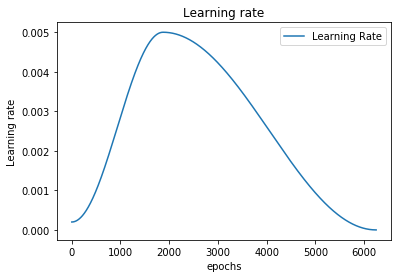

In [180]:
#plot learning rate
plt.figure()
plt.plot(lr_find_lr, label = 'Learning Rate')
#plt.plot(val_accuracy, label = 'Validation Accuracy')
plt.title('Learning rate')
plt.xlabel('epochs')
plt.ylabel('Learning rate')
plt.legend()

In [181]:
# plot loss
loss = epoch_loss[::2]
val_loss = epoch_loss[1::2]

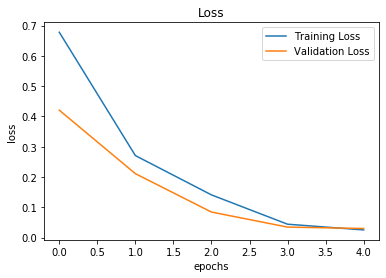

In [182]:
#plot loss
plt.figure()
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

Let's try an alternative model where we know explicity the range of output rating between [0,5] and we apply the output to a sigmoid function to restrict the output to this range

In [112]:
class CollabModel2(nn.Module):
    
    def __init__(self, no_factors, no_users, no_items):
        super(CollabModel2, self).__init__()
        self.user_weight = nn.Parameter(torch.randn(no_users, no_factors))
        self.user_bias = nn.Parameter(torch.randn(no_users, 1))
        self.item_weight = nn.Parameter(torch.randn(no_items, no_factors))
        self.item_bias = nn.Parameter(torch.randn(no_items, 1))
        self.y_min = 0
        self.y_max = 5.5
    def forward(self, users, items):
        # at each step we are given a number of rows for user,item pairs
        # first we get the embedding of each user and each item 
        # and do a dot product to get a rating per (user,item) pair
        # 1st: do element wise product
        # Note that the data is indexed from 1 so we subtract 1 to get the embedding
        dot = self.user_weight[users - 1, :] * self.item_weight[items - 1, :]
        # 2nd: sum along the y-axis
        dot = dot.sum(1) + self.user_bias[users - 1].squeeze() +  self.item_bias[items - 1].squeeze()
        return torch.sigmoid(dot) * (self.y_max - self.y_min) + self.y_min

In [165]:
model = CollabModel2(40, no_users, no_movies)
model

CollabModel2()

In [166]:
# Gather the parameters to be optimized/updated in this run.
# we will only update the parameters that we have just initialized
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

	 user_weight
	 user_bias
	 item_weight
	 item_bias


In [167]:
batch_size = 64
X_train_tensor = torch.from_numpy(X_train[['user id', 'item id']].values).long()
y_train_tensor = torch.from_numpy(X_train[['rating']].values).float()
X_val_tensor = torch.from_numpy(X_val[['user id', 'item id']].values).long()
y_val_tensor = torch.from_numpy(X_val[['rating']].values).float()
train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size)
val_dataloader = DataLoader(dataset=val_data, batch_size=batch_size)
dataloaders = {'train': train_dataloader, 'val':val_dataloader}
dataset_sizes = {'train': len(X_train), 'val': len(X_val)}

In [168]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(params_to_update,lr=5e-6, weight_decay=1e-1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=5e-6, epochs=5, steps_per_epoch=dataset_sizes['train']//batch_size)

In [169]:
epoch_loss, lr_find_lr = train_model(model, criterion, optimizer, scheduler,  dataset_sizes, batch_size, num_epochs=5)

Epoch 0/4
----------
Progress: [==========] train Loss: 0.1190
val Loss: 0.1204

Epoch 1/4
----------
Progress: [==========] train Loss: 0.1189
val Loss: 0.1203

Epoch 2/4
----------
Progress: [==========] train Loss: 0.1188
val Loss: 0.1203

Epoch 3/4
----------
Progress: [==========] train Loss: 0.1188
val Loss: 0.1203

Epoch 4/4
----------
Progress: [==========] train Loss: 0.1187
val Loss: 0.1203

Training complete in 0m 38s


our model got ?? MSE  on the training dataset and ?? MSE on the validation dataset. we can plot a graph of the loss and learning rate as they progress over the epochs. 

In [170]:
# plot loss
loss = epoch_loss[::2]
val_loss = epoch_loss[1::2]

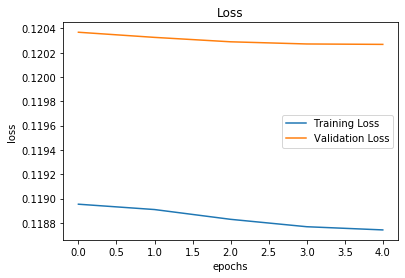

In [171]:
#plot loss
plt.figure()
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()